In [1]:
%matplotlib inline
import os

import matplotlib.pyplot as plt
from moviepy.editor import ImageSequenceClip
import numpy as np
import pandas as pd
import seaborn as sns

from nba_utils import draw_court, draw_3pt_piechart, plot_shot_chart
from pyspark.sql.functions import array, col, count, mean, sum, udf, when
from pyspark.sql.types import IntegerType

sns.set_style("white")
sns.set_color_codes()
display(HTML('<style>.container {width:80% !important;}</style>'))

/Users/crawles/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Create Spark dataframe

In [4]:
df = spark.read\
          .option('header', 'true')\
          .option('inferSchema', 'true')\
          .csv('data/shot_charts_top_10/1000_plus_shot_charts_2011_2016.csv')
df.cache()
df.count()

243719

# Determine if shot is a 3 pointer

In [5]:
def is_corner_3(xy):
    '''Want to identify corner 3 point attempts'''
    x,y = xy
    return int((abs(x) >= 220) and (y < 92.5))

def is_normal_3(xycorner3):
    '''Want to identify normal (not corner 3) point attempts'''
    x,y,corner3 = xycorner3
    radius = 475/2.
    y_3pt = np.sqrt(np.square(radius) - np.square(x))
    return int(y > max(92.5,y_3pt) and not corner3)

corner_3_udf = udf(is_corner_3, IntegerType())
normal_3_udf = udf(is_normal_3, IntegerType())

df2 = df.withColumn('corner_3', corner_3_udf(array([df.x,df.y])))
df3 = df2.withColumn('normal_3', normal_3_udf(array([df2.x,df2.y,df2.corner_3])))
df4 = df3.withColumn('is_a_3', df3.corner_3 + df3.normal_3) 

df = df4
df.cache()

DataFrame[_c0: int, yr: int, name: string, team_name: string, game_date: timestamp, season: int, espn_player_id: int, team_id: int, espn_game_id: double, period: int, minutes_remaining: int, seconds_remaining: int, shot_made_flag: int, action_type: string, shot_type: string, shot_distance: int, opponent: string, x: int, y: int, dribbles: double, touch_time: double, defender_name: string, defender_distance: double, shot_clock: double, corner_3: int, normal_3: int, is_a_3: int]

## Plot corner 3, normal 3, all

In [6]:
# make shot charts for all years
midrange_thresh = 8
in_half_court = 'y <= 400 and abs(x) <= 250' 
addl_filter = 'shot_distance > {midrange_thresh}'.format(midrange_thresh = midrange_thresh)
for yr in range(2011,2016+1):
    df_yr = df.filter('''{in_half_court}
                         and yr == {yr}
                         and {addl_filter}'''.format(in_half_court = in_half_court,
                                                     yr = yr,
                                                     addl_filter = addl_filter))
    x = np.array([v[0] for v in df_yr.select('x').collect()])
    y = np.array([v[0] for v in df_yr.select('y').collect()])
    p = plot_shot_chart(x,y, gridsize = 30, kind = 'kde', label = yr)
    p.fig.suptitle('Evolution of the 3 point shot', x = .19, y = 0.86, size = 20, fontweight= 'bold')
    
    per_3 = df_yr.select(mean(df_yr.is_a_3)).take(1)[0][0]
    per_midrange = 1 - per_3
    draw_3pt_piechart(per_3, per_midrange)
    
    plt.savefig('results/all_years/{}.png'.format(yr))
    plt.close()

In [7]:
# convert to gif
fnames = ['results/all_years/{}'.format(f) for f in os.listdir('results/all_years') if not f.startswith('.')]
clip = ImageSequenceClip(fnames, fps = 0.5, ismask = False, with_mask = True)
clip.write_gif('results/evolution_3pt.gif', program = 'ffmpeg') 


[MoviePy] >>>> Building file results/evolution_3pt.gif
[MoviePy] Generating GIF frames...


 86%|████████▌ | 6/7 [00:00<00:00, 24.39it/s]

[MoviePy] >>>> File results/evolution_3pt.gif is ready !

# Points per shot

In [8]:
shot_acc = df.groupBy('shot_distance','corner_3','normal_3','is_a_3')\
             .agg(count('*').alias('num_attempts'),mean(df.shot_made_flag).alias('shot_accuracy'))\
             .withColumn('points_per_shot',when(col('is_a_3') == 1, col('shot_accuracy')*3)
                                           .otherwise(col('shot_accuracy')*2)
                        )\
             .filter('num_attempts > 5')\
             .orderBy('shot_distance')\
             .toPandas()

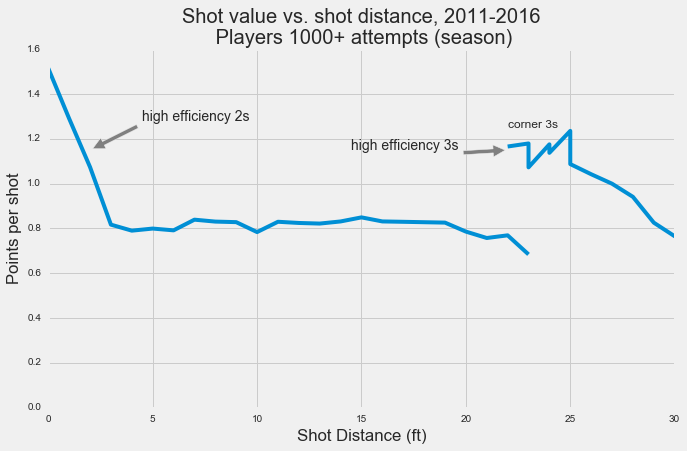

In [9]:
plt.style.use('fivethirtyeight')
plt.figure(figsize = (10,6))

def plot_acc_vs_dist(df,kwargs = {}):
    plt.plot(df.shot_distance, df.points_per_shot, **kwargs)
    
plot_acc_vs_dist(shot_acc.query('is_a_3 == False'), {'color' : '#008fd5'})
plot_acc_vs_dist(shot_acc.query('is_a_3 == True'), {'color' : '#008fd5'})
plt.title('Shot value vs. shot distance, 2011-2016\n Players 1000+ attempts (season)')
plt.xlim(0,30)
plt.xlabel('Shot Distance (ft)')
plt.ylabel('Points per shot')
plt.annotate('high efficiency 2s', xy=(2., 1.15), xytext=(4.5, 1.28),
            arrowprops=dict(facecolor='grey', shrink=0.05),
            )
plt.annotate('high efficiency 3s', xy=(22, 1.15), xytext=(14.5, 1.15),
            arrowprops=dict(facecolor='grey', shrink=0.05),
            )
plt.text(22, 1.25, 'corner 3s', fontsize = 12)

# Appendix

### Downloaded shot charts from NBA savant, all shots from players with at least 1000 attempts 2011-2012 --> 2015-2016 season

In [2]:
def read_csv_dir(dirname):
    dfs = []
    filenames = [f for f in os.listdir(dirname) if not f.startswith('.')]
    for f in filenames:
        df = pd.read_csv(os.path.join(dirname,f))
        dfs.append(df)
    return pd.concat(dfs)

_dfs = []
for yr in range(2011,(2016+1)):
  dirname = 'data/shot_charts_top_10/{yr}'.format(yr = yr)
  df = read_csv_dir(dirname)
  df.insert(0, 'yr', yr)
  _dfs.append(df)
shot_df = pd.concat(_dfs, ignore_index = True)
shot_df.to_csv('data/shot_charts_top_10/1000_plus_shot_charts_2011_2016.csv')

In [3]:
shot_df = pd.read_csv('data/shot_charts_top_10/1000_plus_shot_charts_2011_2016.csv')

## View shot type

(0, 800)

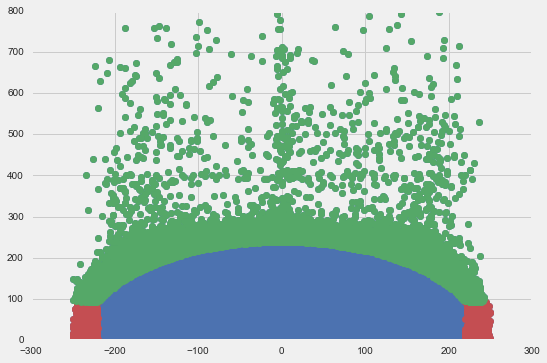

In [10]:
def col2list(df,col):
    return np.array([v[0] for v in df.select(col).collect()])

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(col2list(df,'x'), col2list(df,'y'), 'bo')
ax.plot(col2list(df.filter('corner_3 == 1'),'x'),
        col2list(df.filter('corner_3 == 1'),'y'),
        'ro')
ax.plot(col2list(df.filter('normal_3 == 1'),'x'),
        col2list(df.filter('normal_3 == 1'),'y'),
        'go')

plt.xlim(-300,300)
plt.ylim(0,800)

# Create indiv player shot chart

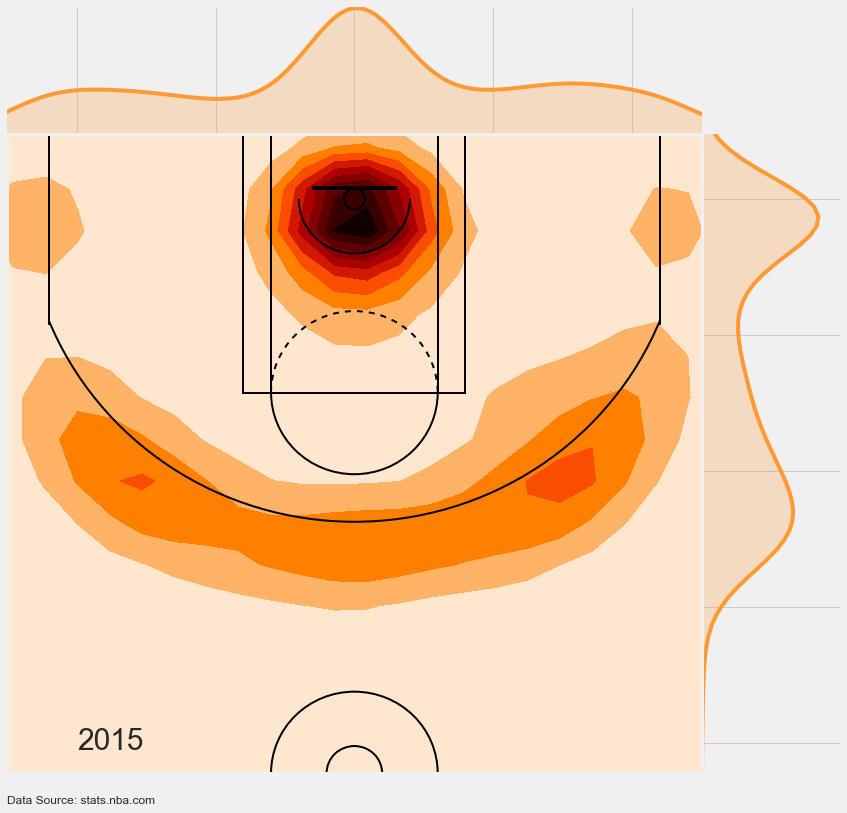

In [11]:
player = 'Stephen Curry'
yr = '2016'
df_jh = df.filter('name == "{player}" and yr == {yr}'.format(player = player,
                                                             yr = yr))
x = np.array([v[0] for v in df_jh.select('x').collect()])
y = np.array([v[0] for v in df_jh.select('y').collect()])
_=plot_shot_chart(x, y, gridsize = 30,
                      kind='kde',
                      label='2015')